<a href="https://colab.research.google.com/github/unclepeddy/deeplearning/blob/master/8-tfx/apache_beam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q -U \
  tensorflow==2.0.0 \
  apache-beam?

In [0]:
from datetime import datetime
import os
import pprint
import tempfile
import urllib
pp = pprint.PrettyPrinter()

import tensorflow as tf

import apache_beam as beam
from apache_beam import pvalue
from apache_beam.runners.interactive.display import pipeline_graph
import graphviz

In [0]:
print("Tensorflow version: {}".format(tf.__version__))
print("Beam version: {}".format(beam.__version__))

In [0]:
# Create a `PCollection` and run it through a single `ParDo` Transform.
## A `PCollection` is an immutable, bounded or unbounded collection of values of type `T` used as inputs or outputs of Transforms.

with beam.Pipeline() as pipeline:
  lines = (pipeline
          | "Create values" >> beam.Create(["a", "bunch", "of", 3])
          | "Print values" >> beam.ParDo(print))

def display_pipeline(pipeline):
  graph = pipeline_graph.PipelineGraph(pipeline)
  return graphviz.Source(graph.get_dot())

display_pipeline(pipeline)

In [0]:
# A Map transform applies a simple 1-to-1 mapping function over each element in the collection
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | "Create" >> beam.Create(["The first", "the second", "and the third"])
           | "Split" >> beam.Map(lambda s: s.split())
           | "Print" >> beam.ParDo(print))

In [0]:
# Create DoFn classes to feed to ParDo transforms - FlatMap is similar to ParDo
# except in that it takes a callable
class Splitter(beam.DoFn):
  def process(self, element):
    return element.split()

with beam.Pipeline() as pipeline:
  lines = (pipeline
           | "Create" >> beam.Create(["The first", "the second", "and the third"])
           | "Split" >> beam.ParDo(Splitter())
           | "Print" >> beam.ParDo(print))
  
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | "Create" >> beam.Create(["The first", "the second", "and the third"])
           | "Split" >> beam.ParDo(lambda s: s.split())
           | "Print" >> beam.ParDo(print))

In [0]:
# You can use GroupByKey to group values of the same key in a multimap
with beam.Pipeline() as pipeline:
  lines = (pipeline 
           | "Create" >> beam.Create(range(10+1))
           | "Map" >> beam.Map(lambda num: ("even" if num % 2 == 0 else "odd", num))
           | "Group" >> beam.GroupByKey()
           | "Print" >> beam.ParDo(print)) 

In [0]:
# Combine takes a commutative and associative function and uses it combine key/values across PCollections

class AverageFn(beam.CombineFn):
  def create_accumulator(self):
    return (0.0, 0)
  def merge_accumulators(self, accs):
    total, count = zip(*accs)
    return sum(total), sum(count)
  def add_input(self, acc, input):
    total, count = acc
    total += input
    count += 1
    return (total, count)
  def extract_output(self, acc):
    total, count = acc
    return total / count if count else float("NaN")

with beam.Pipeline() as p:
  lines = (p
           | beam.Create([1, 5, 4, 10])
           | beam.CombineGlobally(AverageFn())
           | beam.ParDo(print))

In [0]:
# Flatten and Partition can be used to merge and partition (into a fixed number collections)
# collections of the same type
def partition_fn(number, num_partitions):
  return min(number // 100, num_partitions - 1)

with beam.Pipeline() as p:
  lines = (p
           | beam.Create([1, 200, 4123, 1000, 30, 400])
           | beam.Partition(partition_fn, 3))

  lines[0] | "small" >> beam.ParDo(print, "Small")
  lines[1] | "medium" >> beam.ParDo(print, "Medium")
  lines[2] | "large" >> beam.ParDo(print, "Large")
  

In [0]:
# Side inputs and additional outputs can inject and extract additional data
# From `ParDo` operations

import random

def increment(number, inc=1):
  return number + inc

  
def compute(number):
  if number % 2 == 0:
    yield number
  else:
    yield pvalue.TaggedOutput("odd", number + 10)

with beam.Pipeline() as p:
  lines = (p
           | "Create" >> beam.Create([1,2,3,4])
           | "Increment" >> beam.Map(increment, random.randint(0, 10))) # The same random number will be provided to all maps

  lines | "Print" >> beam.ParDo(print, "Raw")

  evens, odds = (lines 
                | "Compute" >> beam.ParDo(compute).with_outputs("odd", main="even"))

  evens | "Evens" >> beam.ParDo(print, "Even")
  evens | "Odds" >> beam.ParDo(print, "Odd")

In [0]:
# Composite Transforms help you combine and nest individual Transforms

class ExtractAndMultiply(beam.PTransform):
  def expand(self, pcollection):
    return (pcollection 
            | beam.FlatMap(lambda a : a.split(","))
            | beam.Map(lambda x : int(x) * 10))
    
with beam.Pipeline() as p:
  lines = (p
           | beam.Create(['1,2,3,4,5', '6,7,8,9'])
           | ExtractAndMultiply()
           | beam.ParDo(print))

In [0]:
# Pass the data to the filter Transform as an iterator if they don't fit in memory
class FilterOddNumbers(beam.DoFn):
   def process(self, el, *args, **kwargs):
     if el % 2 == 1: 
       yield el

with beam.Pipeline() as p:
  not_in_mem = (p
           | "Create" >> beam.Create(range(20))
           | "Filter" >> beam.ParDo(FilterOddNumbers())
           | "Print" >> beam.ParDo(print))

  in_mem = (p
           | "Mem Create" >> beam.Create(range(20))
           | "Mem Filter" >> beam.Filter(lambda x: x%2 == 1)
           | "Mem Print" >> beam.ParDo(print))


In [92]:
# Pipeline I/O for a number of common data formats

DATA_PATH = 'https://raw.githubusercontent.com/ageron/open-datasets/master/' \
   'online_news_popularity_for_course/online_news_popularity_for_course.csv'
_data_root = tempfile.mkdtemp(prefix='tfx-data')
_data_filepath = os.path.join(_data_root, "data.csv")
urllib.request.urlretrieve(DATA_PATH, _data_filepath)

('/tmp/tfx-data8w21_hzs/data.csv', <http.client.HTTPMessage at 0x7f15c70e6b70>)

In [0]:
with beam.Pipeline() as p:
  lines = (p
           | beam.io.ReadFromText(_data_filepath)
           | beam.Filter(lambda line: line.startswith("2013-01-07"))
           | beam.ParDo(print))

2013-01-10 ('Entertainment', 0.4934309586085392)
2013-01-17 ('Entertainment', 0.3993314203305976)
2013-01-24 ('Entertainment', 0.4357401844154913)
2013-01-31 ('Entertainment', 0.4075013381809972)
2013-02-07 ('Entertainment', 0.4103427648932644)
2013-02-14 ('Entertainment', 0.4271943372942263)
2013-02-21 ('Entertainment', 0.4975377736858036)
2013-02-28 ('Entertainment', 0.4202564461639628)
2013-03-07 ('Entertainment', 0.4576463700006986)
2013-03-14 ('Entertainment', 0.5748964251223644)
2013-03-21 ('Entertainment', 0.5160059735729626)
2013-03-28 ('Entertainment', 0.5456083263855331)
2013-04-04 ('Entertainment', 0.4896692542797565)
2013-04-11 ('Entertainment', 0.5841481246586686)
2013-04-18 ('Entertainment', 0.5430426953734391)
2013-04-25 ('Entertainment', 0.5524051558873977)
2013-05-02 ('Entertainment', 0.5020259476003092)
2013-05-09 ('Entertainment', 0.49738832324102417)
2013-05-16 ('Entertainment', 0.3413786269224671)
2013-05-23 ('Entertainment', 0.3948188170492027)
2013-05-30 ('Entert

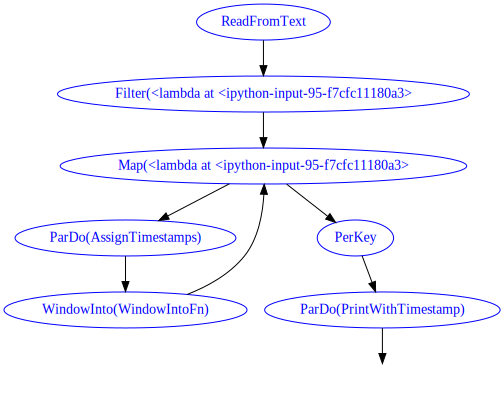

In [95]:
# You can use windowing to turn unbounded PCollections into bounded objects
DAYS = 24 * 60 * 60

class AssignTimestamps(beam.DoFn):
  def process(self, element):
    date = datetime.strptime(element[0], "%Y-%m-%d")
    yield beam.window.TimestampedValue(element, date.timestamp())

class PrintWithTimestamp(beam.DoFn):
  def process(self, element, timestamp=beam.DoFn.TimestampParam):
    print(timestamp.to_rfc3339()[:10], element)

with beam.Pipeline() as ts_pipeline:
  lines = (ts_pipeline
           | beam.io.ReadFromText(_data_filepath)
           | beam.Filter(lambda line: line < "2014-01-01")
           | beam.Map(lambda line: line.split(",")) # CSV parser?
           | beam.ParDo(AssignTimestamps())
           | beam.WindowInto(beam.window.FixedWindows(7 * DAYS))
           | beam.Map(lambda cols: (cols[2], float(cols[-1])))
           | beam.combiners.Mean.PerKey()
           | beam.ParDo(PrintWithTimestamp()))

display_pipeline(ts_pipeline)